## GPTS TimeSformer on UWHVF dataset

0. Import necessary packages

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Dataloader import dataloaders
from sklearn.metrics import confusion_matrix, accuracy_score

1. Preprocess data with data_preprocessing.py

In [13]:
%run data_preprocessing.py

Length of prog_labellist, total number of subjects with 3+ frames: 2991
Progressing number of subjects (1): 2200
Data preprocessing complete!


2. Set random seed for reproducability

In [14]:
torch.manual_seed(42)
np.random.seed(42)

2. Define Dataset class and DataLoaders with Dataloader.py

In [15]:
%run Dataloader.py

Dataset and Dataloader complete!


3. Define Model

In [16]:
%run Model.py

4. Make a folder to save model at the end of each epoch

In [17]:
!mkdir saved_models_GPTS

mkdir: saved_models_GPTS: File exists


5. Define optimizer, create instance of model, and enter training/validation loop with training_func.py

In [18]:
%run training_func.py

Epoch: 0 | train_loss: 1.2803165364425784 | validation_loss: 0.7193799080948035
Epoch: 1 | train_loss: 0.5317584000263433 | validation_loss: 0.7038710365692774
Epoch: 2 | train_loss: 0.5226710496746424 | validation_loss: 0.8495045688003302
Epoch: 3 | train_loss: 0.5176696583379783 | validation_loss: 0.6231267945220073
Epoch: 4 | train_loss: 0.5113266294273803 | validation_loss: 0.6132440501203139
Training accuracy average: 75.06 %
Validation accuracy average: 63.34 %
Training and validation complete!


6. Run model with test data

In [24]:
from Model import GPTS
from torch.optim import SGD
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GPTS().to(device)
optimizer = SGD(model.parameters(),lr=0.1)
criterion = nn.BCEWithLogitsLoss()

test_accuracy = []          # test accuracy per epoch
test_epoch_loss = []        # test loss per epoch

for epoch in range(5):
    temp_loss = []
    predict_labels = []
    true_labels = [] 
    
    model.eval()
    
    for index, (data, label) in enumerate(dataloaders['test']):
        data = data.to(device)
        label = label.unsqueeze(1).to(device)
        
        label_predicted = model(data.float())
        
        loss = criterion(label_predicted, label.float())
        temp_loss.append(loss.data.item())
        
        preds_binary = (label_predicted>=0)
        preds_binary_array = preds_binary.cpu().numpy()
        labels_array = label.data.cpu().numpy()
        
        predict_labels.extend(preds_binary_array)
        true_labels.extend(labels_array)
    
    test_epoch_loss.append(np.mean(temp_loss))
    accuracy = accuracy_score(true_labels, predict_labels)
    test_accuracy.append(accuracy)
    
    print("Epoch: {} | test_loss: {} ".format(epoch, test_epoch_loss[-1]))

test_accuracy_avg = (sum(test_accuracy)/len(test_accuracy))*100     # avg test accuracy across all epochs
print("Test accuracy average:",round(test_accuracy_avg, 2),"%")


Epoch: 0 | test_loss: 0.6658207654953003 
Epoch: 1 | test_loss: 0.6658207654953003 
Epoch: 2 | test_loss: 0.6658207654953003 
Epoch: 3 | test_loss: 0.6658207654953003 
Epoch: 4 | test_loss: 0.6658207654953003 
Test accuracy average: 66.89 %


7. Additional metrics (confusion matrix)

Text(0.5, 3.722222222222216, 'Predicted Labels')

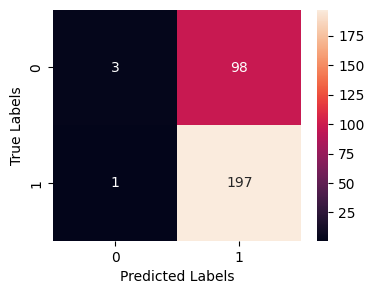

In [25]:
CM_test_lastbatch = confusion_matrix(true_labels, predict_labels)
plt.figure(figsize = (4,3))
sns.heatmap(CM_test_lastbatch, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')